# ConvLSTM Physics-Informed Model

### This notebook demonstrates the integration of physics laplacians with a ConvLSTM.

In [1]:
import os
import numpy as np
from glob import glob
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split



In [ ]:
# loading image sequences

def load_runs(base_dir="bacteria_growth", img_size=40):
    runs = sorted(glob(os.path.join(base_dir, "run_*")))
    all_sequences = []

    for run_path in runs:
        frames = sorted(glob(os.path.join(run_path, "frame_*.png")))
        imgs = []
        for f in frames:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype(np.float32) / 255.0
            imgs.append(img)
        all_sequences.append(np.stack(imgs, axis=0))  # shape: (T, H, W)
    return all_sequences

sequences = load_runs("bacteria_growth", img_size=40)



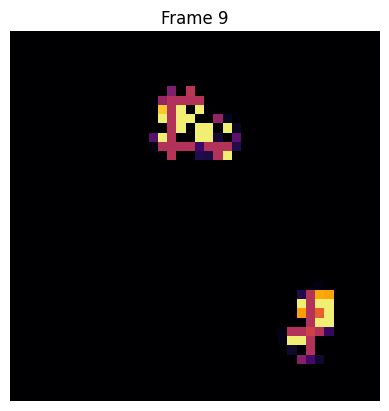

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

# Pick a run
seq = sequences[0]

fig, ax = plt.subplots()
im = ax.imshow(seq[0], cmap='inferno', vmin=0, vmax=1)
ax.axis('off')

def update(frame):
    im.set_data(seq[frame])
    ax.set_title(f"Frame {frame}")
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(seq), interval=200, blit=True)
HTML(ani.to_jshtml())


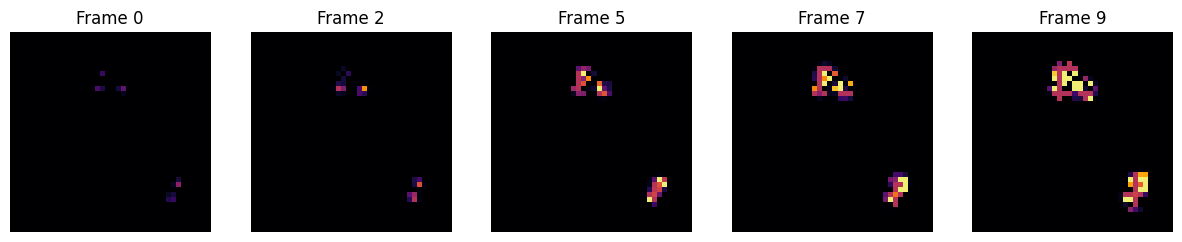

In [4]:
import matplotlib.pyplot as plt

seq = sequences[0]  # pick a run
frames_to_show = [0, len(seq)//4, len(seq)//2, 3*len(seq)//4, len(seq)-1]

plt.figure(figsize=(15, 3))
for i, f in enumerate(frames_to_show):
    plt.subplot(1, len(frames_to_show), i+1)
    plt.imshow(seq[f], cmap='inferno', vmin=0, vmax=1)
    plt.title(f"Frame {f}")
    plt.axis('off')
plt.show()


In [ ]:
# creation of training windows

def create_input_output_pairs(sequences, input_len=5, pred_len=5, stride=1):
    X, Y = [], []
    for seq in sequences:
        T = seq.shape[0]
        for start in range(0, T - input_len - pred_len + 1, stride):
            x = seq[start : start + input_len]
            y = seq[start + input_len : start + input_len + pred_len]
            X.append(x)
            Y.append(y)
    X = np.expand_dims(np.array(X), -1)  # (num_samples, input_len, H, W, 1)
    Y = np.expand_dims(np.array(Y), -1)  # (num_samples, pred_len, H, W, 1)
    return X, Y

X, Y = create_input_output_pairs(sequences, input_len=5, pred_len=5, stride=1)

print("Input shape:", X.shape, "Target shape:", Y.shape)



Input shape: (10, 5, 40, 40, 1) Target shape: (10, 5, 40, 40, 1)


Input shape: (10, 5, 40, 40, 1)
Target shape: (10, 5, 40, 40, 1)

Sample index: 6
x_sample shape: (5, 40, 40, 1)
y_sample shape: (5, 40, 40, 1)


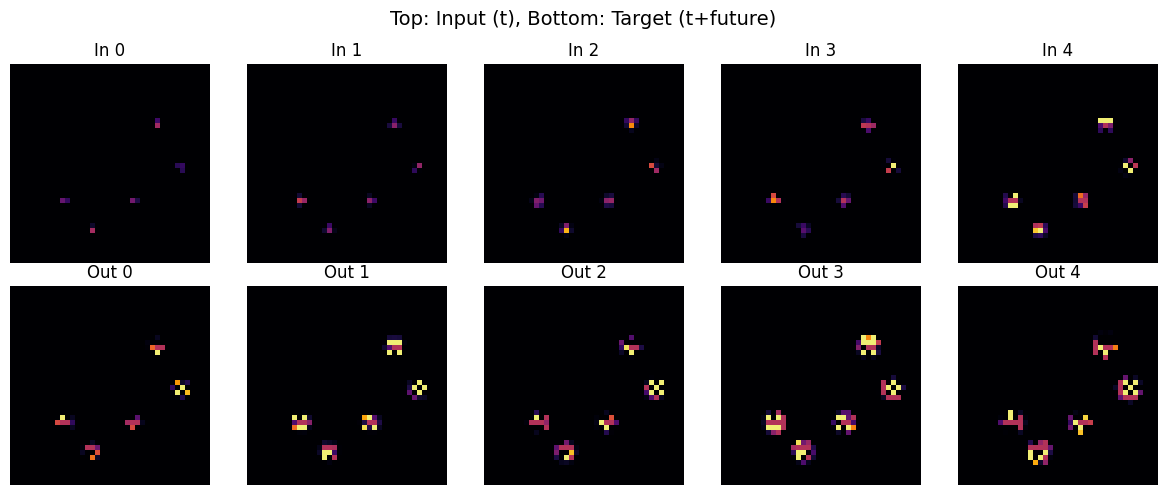

In [6]:
import matplotlib.pyplot as plt

# Print shapes
print("Input shape:", X.shape)   # (num_samples, input_len, H, W, 1)
print("Target shape:", Y.shape)  # (num_samples, pred_len, H, W, 1)

# Pick a random sample
idx = np.random.randint(0, len(X))
x_sample = X[idx]  # shape (input_len, H, W, 1)
y_sample = Y[idx]  # shape (pred_len, H, W, 1)

print(f"\nSample index: {idx}")
print("x_sample shape:", x_sample.shape)
print("y_sample shape:", y_sample.shape)

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Top: Input (t), Bottom: Target (t+future)", fontsize=14)

for i in range(5):
    # Input frames
    axes[0, i].imshow(x_sample[i, :, :, 0], cmap='inferno', vmin=0, vmax=1)
    axes[0, i].set_title(f"In {i}")
    axes[0, i].axis('off')
    
    # Target frames
    axes[1, i].imshow(y_sample[i, :, :, 0], cmap='inferno', vmin=0, vmax=1)
    axes[1, i].set_title(f"Out {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# training and validatoin split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)



Training set: (8, 5, 40, 40, 1) (8, 5, 40, 40, 1)
Validation set: (2, 5, 40, 40, 1) (2, 5, 40, 40, 1)


In [ ]:
# define the convlstm model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv3D
from tensorflow.keras.optimizers import Adadelta

model = Sequential([
    ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(None, 40, 40, 1),
               padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True),
    BatchNormalization(),

    # Use temporal kernel of 1 → preserves number of frames (time dimension)
    Conv3D(filters=1, kernel_size=(1, 3, 3), activation='sigmoid',
           padding='same', data_format='channels_last')
])


import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy

# Laplace kernel for diffusion regularization
laplace_kernel = tf.constant(
    [[0, 1, 0],
     [1,-4, 1],
     [0, 1, 0]], dtype=tf.float32)
laplace_kernel = laplace_kernel[:, :, tf.newaxis, tf.newaxis]

def laplacian(x):
    return tf.nn.conv2d(x, laplace_kernel, strides=1, padding='SAME')

def tv_loss(y_pred):
    dx = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
    dy = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
    return tf.reduce_mean(tf.abs(dx)) + tf.reduce_mean(tf.abs(dy))

def physics_loss(y_true, y_pred):
    recon = tf.reduce_mean(binary_crossentropy(y_true, y_pred))
    lap = tf.reduce_mean(tf.abs(laplacian(y_pred)))
    tv  = tv_loss(y_pred)
    return recon + 0.01 * lap + 0.001 * tv


model.compile(loss=physics_loss, optimizer=Adadelta())
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, None, 40, 40,   │        59,200 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_14 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_15 (ConvLSTM2D)     │ (None, None, 40, 40,   │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, None, 40, 40,   │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, None, 40, 40,   │           361 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,281 (1.55 MB)

 Trainable params: 405,961 (1.55 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:

# training

history = model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=3000,
    validation_data=(X_val, Y_val)
)


model.save("trained_model.h5")
print("Model saved as trained_model.h5")

# save training history

import json
with open("training_history.json", "w") as f:
    json.dump(history.history, f)

print("Training history saved as training_history.json")

Epoch 1/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 0.8740 - val_loss: 0.6935
Epoch 2/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.8726 - val_loss: 0.6934
Epoch 3/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.8708 - val_loss: 0.6933
Epoch 4/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.8690 - val_loss: 0.6932
Epoch 5/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.8670 - val_loss: 0.6930
Epoch 6/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.8657 - val_loss: 0.6929
Epoch 7/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.8641 - val_loss: 0.6928
Epoch 8/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.8624 - val_loss: 0.6927
Epoch 9/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.8609 - val_loss: 0.6925
Epoch 10/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.8593 - val_loss: 0.6924
Epoch 11/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.8577 - val_loss: 0.6923
Epoch 12/3000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - 

Model saved as trained_model.h5
Training history saved as training_history.json


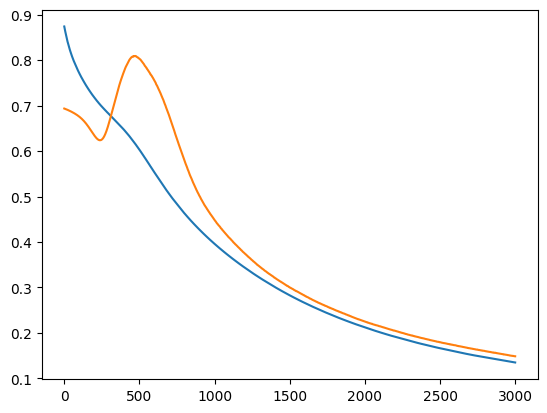

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.models import load_model
import json

# include custom_objects
model = load_model(
    "trained_model.h5",
    custom_objects={"physics_loss": physics_loss}
)



with open("training_history.json") as f:
    history = json.load(f)

# Example: plot loss
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.show()


In [ ]:

# evaluate with offset prediction

def offset_prediction(model, seq, input_len=5, pred_len=10, offset=0):
    """
    Predict future frames given a starting offset.
    Example: offset=0 → use frames [0–4] → predict [5–14]
             offset=4 → use frames [4–8] → predict [9–18]
    """
    start = offset
    input_seq = seq[start:start + input_len]
    input_seq = np.expand_dims(np.expand_dims(input_seq, axis=0), -1)  # (1, t, H, W, 1)
    pred = model.predict(input_seq)
    return pred[0, :, :, :, 0]

# Example usage on first validation sequence:
example_seq = X_val[0, :, :, :, 0]  # original frames
predicted_future = offset_prediction(model, X_val[0, :, :, :, 0], input_len=5, pred_len=5, offset=0)


print("Predicted future shape:", predicted_future.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
Predicted future shape: (5, 40, 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


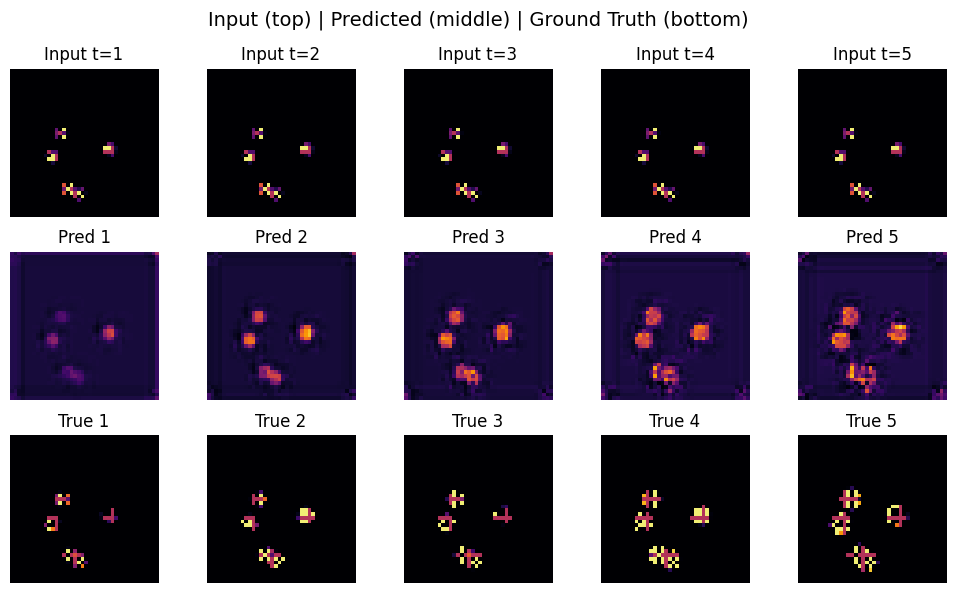

In [ ]:
import matplotlib.pyplot as plt

# use X_val as input, Y_val as ground truth
input_len = 5
pred_len = 5

input_seq = X_val[0, :, :, :, 0]
true_future = Y_val[0, :, :, :, 0]
predicted_future = offset_prediction(model, X_val[0, :, :, :, 0], input_len=input_len, pred_len=pred_len, offset=0)

# Plot input frames, predicted future, and ground truth future
fig, axes = plt.subplots(3, pred_len, figsize=(pred_len * 2, 6))

for i in range(pred_len):
    # Input (last frame repeated for context)
    axes[0, i].imshow(input_seq[-1], cmap='inferno', vmin=0, vmax=1)
    axes[0, i].set_title(f"Input t={i+1}")
    axes[0, i].axis("off")
    
    # Prediction
    axes[1, i].imshow(predicted_future[i], cmap='inferno', vmin=0, vmax=1)
    axes[1, i].set_title(f"Pred {i+1}")
    axes[1, i].axis("off")
    
    # Ground truth
    axes[2, i].imshow(true_future[i], cmap='inferno', vmin=0, vmax=1)
    axes[2, i].set_title(f"True {i+1}")
    axes[2, i].axis("off")

plt.suptitle("Input (top) | Predicted (middle) | Ground Truth (bottom)", fontsize=14)
plt.tight_layout()
plt.savefig("results/offset_prediction_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
